In [1]:
import pandas as pd
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# code to regulate the size of plots for the rest of notebook
plt.rc('figure', figsize=(13, 10))
plt.rc('font', size=13)

import j_acquire
import j_prep
import explore
import modeling

# NLP Project

### The Goal: Build a model that can predict what programming language a repository is, given the text of the README file.

## Planning

Possible Hypotheses:
1. The number of links in a readme file is proportional to the popularity of a language
2. There will be files eanding in extensions particular to a language that will indicate which language the project was prepared in (ie, .py files will be in python projects)
3. 

## Acquisition

We chose to look at 11 topics and scrape the readme files of the 30 most starred repos in each topic.
- Topics:
    1. algorithm
    2. bots
    3. data-visualization
    4. deep_learning
    5. javascript
    6. jupyter_notebook
    7. machine_learning
    8. nlp
    9. python
    10. repo_source
    11. testing

We saved the source code of each topic page into a text file for future access and to avoid any access issues. Our create_large_df function scrapes the repo names from each text file, applies Zach's scrape_github_data function to acquire the language type and readme in each repo, drops any null rows, and then combines everything into one large dataframe.

In [2]:
df = explore.make_initial_df()
print(f'There are {df.shape[0]} rows in the resulting dataframe.')

There are 298 rows in the resulting dataframe.


## Preparation

Our prep_readme_data function accomplishes all of the basic clean operations, adds new columns tokenizing, stemming, and lemmatizing the readme contents. 

We also added a number of new features to make modeling easier. 
- General languages: grouping all the popular languages together, and adding the singletons into an 'other' category
- Number of individual words
- Number of unique words
- Number of links
- Counts of each .py, .js & .ipynb extensions

This file can be saved as a .csv for easy access and to save time.

In [3]:
df = explore.add_new_columns(df)
#df.to_csv('prepared_df.csv')
#df = pd.read_csv('prepared_df.csv')

Next we created a dataframe of every word in each of the popular languages: Python, JavaScript, Jupyter Notebooks, C++, TypeScript, Java, other, and all languages together.

In [4]:
word_counts = explore.make_word_counts_df(df)

Lastly, we created a vectorized dataframe with each of the words in the readmes are individual columns, and their importance in each readme are the values. We also added the new columns we created to this datafame for modeling purposes.

In [5]:
vectorized_df = explore.make_vectorized_df(df)

## Exploration

What are the 10 most common words in our dataset?

In [6]:
word_counts.sort_values(by='all', ascending=False)['all'].head(10)

de         1529
python     1372
data       1247
use        1232
model      1154
using      1036
1           990
code        927
install     883
network     761
Name: all, dtype: int64

What are the 10 most common words in each language?

In [7]:
# Python
word_counts.sort_values(by='python', ascending=False)['python'].head(10)

python     923
model      731
data       437
use        402
install    365
code       348
0          348
using      339
_          331
library    321
Name: python, dtype: int64

In [8]:
# JavaScript
word_counts.sort_values(by='javascript', ascending=False)['javascript'].head(10)

de            1496
e              488
que            379
const          365
covid19        361
1              344
para           336
use            329
javascript     318
um             308
Name: javascript, dtype: int64

In [9]:
# Jupyter Notebook
word_counts.sort_values(by='jupyter', ascending=False)['jupyter'].head(10)

data          280
python        279
tensorflow    253
using         240
model         214
use           209
network       205
notebook      199
learning      193
build         190
Name: jupyter, dtype: int64

In [10]:
# C++
word_counts.sort_values(by='c_plus', ascending=False)['c_plus'].head(10)

build      179
1          134
pytorch    133
onnx       130
c          113
support    112
cntk       109
using      107
given      106
2          102
Name: c_plus, dtype: int64

In [11]:
# TypeScript
word_counts.sort_values(by='typescript', ascending=False)['typescript'].head(10)

component    69
using        63
test         57
run          55
storybook    52
build        47
use          46
yarn         46
npm          46
data         44
Name: typescript, dtype: int64

In [12]:
# Java
word_counts.sort_values(by='java', ascending=False)['java'].head(10)

tree      106
binary     93
dp         91
two        88
search     84
dfs        69
table      67
hash       56
list       55
string     46
Name: java, dtype: int64

In [13]:
# Everything else
word_counts.sort_values(by='other', ascending=False)['other'].head(10)

al          374
et          373
network     218
deep        182
learning    176
go          163
code        160
neural      151
2016        147
data        136
Name: other, dtype: int64

During our exploration, we learned that not all words are relevant to the majority of the readmes in our dataset. Therefore, we decided to handle this as such: 
1. We aggregated similar words together (ie, we added together the values for build, building and built; etc.).
2. We dropped all the words where the mean importance was less than 5%.
3. We added a 'politeness' score, adding together each of the 'polite' words like please and thank you.

Then, we split and scaled this dataset, and went ahead and made our prediction dataframes.

In [14]:
# Aggregate similar words
vectorized_df = explore.aggregate_columns(vectorized_df)
# Split & scale data, and make predictions dataframes
X_train_scaled, X_test_scaled, y_train, y_test, train_predictions, test_predictions = explore.get_splits(df, vectorized_df)
# Drop all words that aren't important
X_train_reduced, X_test_reduced = explore.prep_vectorized_df(X_train_scaled, X_test_scaled)

In [15]:
X_train_reduced.shape, X_test_reduced.shape

((208, 198), (90, 198))

In [17]:
# adding together X_train & y_train for exploration
X_train_reduced['y'] = y_train

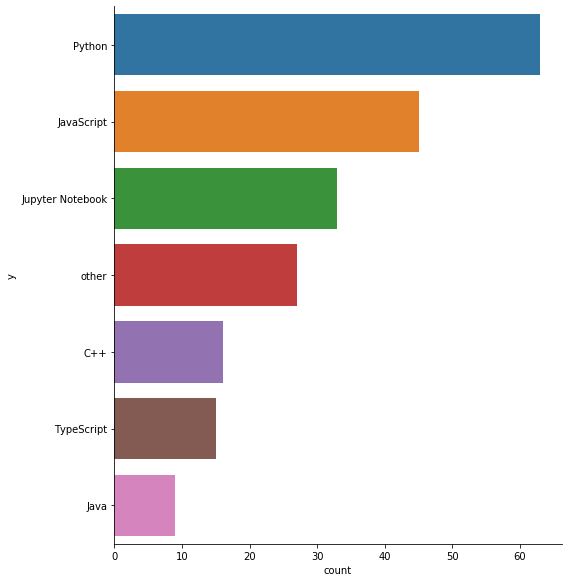

In [18]:
languages = ['Python', 'JavaScript', 'Jupyter Notebook', 'other', 'C++', 'TypeScript', 'Java']

sns.catplot(y='y', kind='count', data=X_train_reduced, height=8, order=languages)

> Our dataset is mostly Python repos, but there are a quite a few of the other languages to compare.

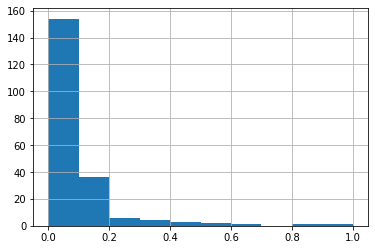

In [19]:
X_train_reduced.num_words.hist()

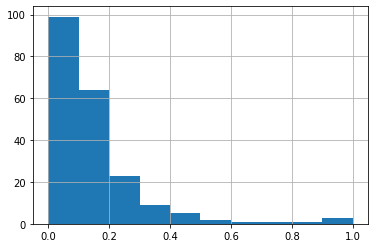

In [20]:
X_train_reduced.num_unique_words.hist()

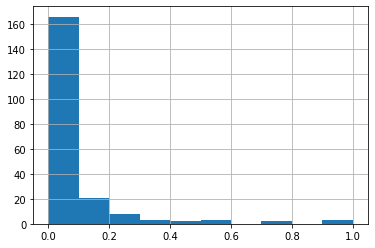

In [21]:
X_train_reduced.link_counts.hist()

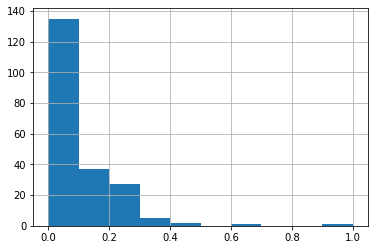

In [22]:
X_train_reduced.politeness.hist()

> Even our engineered and aggregated columns are heavily skewed to small numbers.

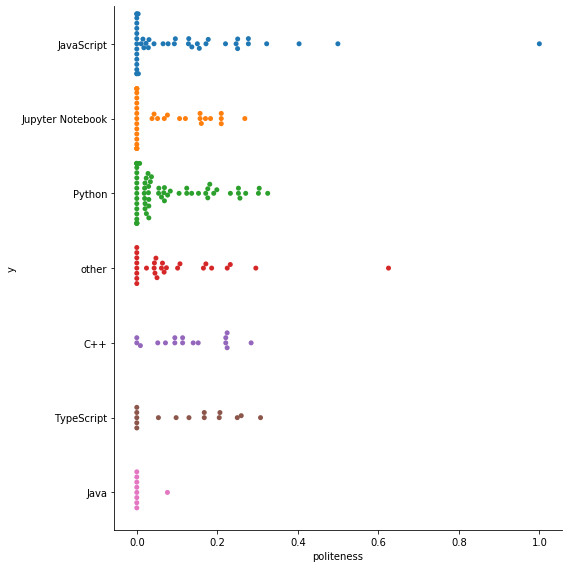

In [23]:
sns.catplot(y="y", x="politeness", kind="swarm", data=X_train_reduced, height=8)

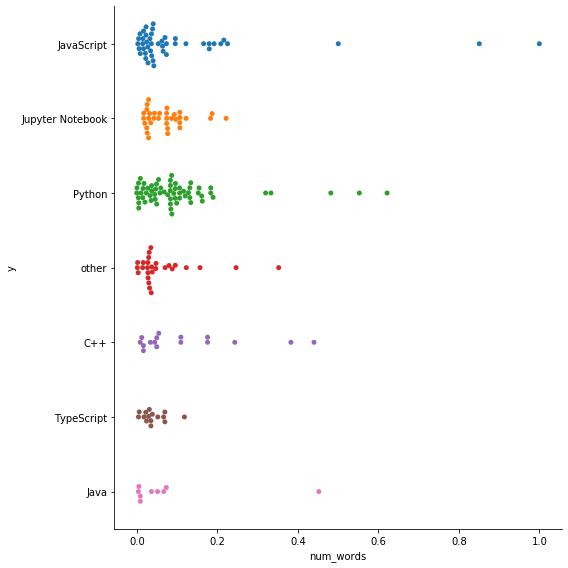

In [24]:
sns.catplot(y="y", x="num_words", kind="swarm", data=X_train_reduced, height=8)

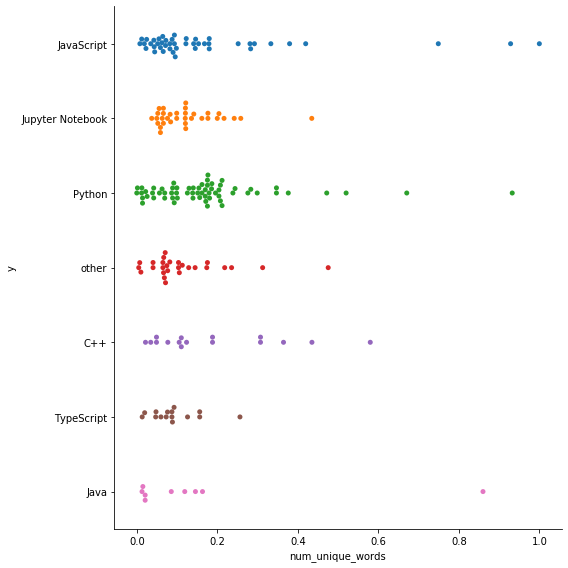

In [25]:
sns.catplot(y="y", x="num_unique_words", kind="swarm", data=X_train_reduced, height=8)

> It looks as though Jupyter Notebook repos use more words and more unique words than other repos.

### Hypothesis Testing

- $H_0$ there is no difference between number of links for javascript repos and the overall average number of links.
- $H_a$ there is a difference between number of links for javascript repos and the overall average number of links.

In [26]:
javascript = X_train_reduced[X_train_reduced['y'] == 'JavaScript']
t, p = stats.ttest_1samp(javascript.link_counts, X_train_reduced.link_counts.mean())

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

t = 1.511
p = 0.138


In [27]:
alpha = 0.05
H_0 = 'There is no difference between number of links for javascript repos and the overall average number of links.'
H_a = 'There is a difference between number of links for javascript repos and the overall average number of links.'

if p < alpha:
    print(f'P value of {p:.3f} is less than alpha, so we reject the null hypothesis. {H_a}')
else:
    print(f'P value of {p:.3f} is greater than alpha, so we fail to reject the null hypothesis. {H_0}')

P value of 0.138 is greater than alpha, so we fail to reject the null hypothesis. There is no difference between number of links for javascript repos and the overall average number of links.


- $H_0$ there is no difference between number of words for python repos and the overall average number of words for all repos.
- $H_a$ there is a difference between number of words for python repos and the overall average number of words for all repos.

In [28]:
python = X_train_reduced[X_train_reduced['y'] == 'Python']
t, p = stats.ttest_1samp(python.num_words, X_train_reduced.num_words.mean())

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

alpha = 0.05
H_0 = 'There is no difference between number of words for python repos and the overall average number of words for all repos.'
H_a = 'There is a difference between number of words for python repos and the overall average number of words for all repos.'

if p < alpha:
    print(f'P value of {p:.3f} is less than alpha, so we reject the null hypothesis. {H_a}')
else:
    print(f'P value of {p:.3f} is greater than alpha, so we fail to reject the null hypothesis. {H_0}')

t = 0.948
p = 0.347
P value of 0.347 is greater than alpha, so we fail to reject the null hypothesis. There is no difference between number of words for python repos and the overall average number of words for all repos.


- $H_0$ there is no difference between the politeness score for python repos and the overall politeness score for all repos.
- $H_a$ there is a difference between the politeness score for python repos and the overall politeness score for all repos.

In [29]:
python = X_train_reduced[X_train_reduced['y'] == 'Python']
t, p = stats.ttest_1samp(python.politeness, X_train_reduced.politeness.mean())

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

alpha = 0.05
H_0 = 'There is no difference between the politeness score for python repos and the overall politeness score for all repos.'
H_a = 'There is a difference between the politeness score for python repos and the overall politeness score for all repos.'

if p < alpha:
    print(f'P value of {p:.3f} is less than alpha, so we reject the null hypothesis. {H_a}')
else:
    print(f'P value of {p:.3f} is greater than alpha, so we fail to reject the null hypothesis. {H_0}')

t = -1.143
p = 0.257
P value of 0.257 is greater than alpha, so we fail to reject the null hypothesis. There is no difference between the politeness score for python repos and the overall politeness score for all repos.


- $H_0$ there is no difference between politeness score for JavaScript repos and the overall politeness score for all repos.
- $H_a$ there is a difference between politeness score for JavaScript repos and the overall politeness score for all repos.

In [30]:
java = X_train_reduced[X_train_reduced['y'] == 'JavaScript']
t, p = stats.ttest_1samp(java.politeness, X_train_reduced.politeness.mean())

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

alpha = 0.05
H_0 = 'There is no difference between politeness score for JavaScript repos and the overall politeness score for all repos.'
H_a = 'There is a difference between politeness score for JavaScript repos and the overall politeness score for all repos.'

if p < alpha:
    print(f'P value of {p:.3f} is less than alpha, so we reject the null hypothesis. {H_a}')
else:
    print(f'P value of {p:.3f} is greater than alpha, so we fail to reject the null hypothesis. {H_0}')

t = 0.975
p = 0.335
P value of 0.335 is greater than alpha, so we fail to reject the null hypothesis. There is no difference between politeness score for JavaScript repos and the overall politeness score for all repos.


- $H_0$ there is no difference between number of words for Jupyter Notebook repos and the overall average number of words for all repos.
- $H_a$ there is a difference between number of words for Jupyter Notebook repos and the overall average number of words for all repos.

In [31]:
jupyter = X_train_reduced[X_train_reduced['y'] == 'Jupyter Notebook']
t, p = stats.ttest_1samp(jupyter.num_words, X_train_reduced.num_words.mean())

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

alpha = 0.05
H_0 = 'There is no difference between number of words for Jupyter Notebook repos and the overall average number of words for all repos.'
H_a = 'There is a difference between number of words for Jupyter Notebook repos and the overall average number of words for all repos.'

if p < alpha:
    print(f'P value of {p:.3f} is less than alpha, so we reject the null hypothesis. {H_a}')
else:
    print(f'P value of {p:.3f} is greater than alpha, so we fail to reject the null hypothesis. {H_0}')

t = -2.245
p = 0.032
P value of 0.032 is less than alpha, so we reject the null hypothesis. There is a difference between number of words for Jupyter Notebook repos and the overall average number of words for all repos.


> AHA! Finally we found something that is significant!

## Modeling

In [32]:
# Drop the y column from X_train_reduced for modeling
X_train_reduced = X_train_reduced.drop(columns='y')

We evaluated multiple models: Logistic Regression, Random Forest & K Nearest Neighbors

In [33]:
train_predictions, test_predictions = modeling.make_predictions_df(X_train_reduced, X_test_reduced, y_train, train_predictions, test_predictions)
modeling.train_evaluation(train_predictions)

Evaluation Metrics for Logistic Regression Model


Accuracy: 92.31%
----------------------------------------------------------------------------------------------
Confusion Matrix
actual            C++  Java  JavaScript  Jupyter Notebook  Python  TypeScript  \
lr_predictions                                                                  
C++                14     0           0                 0       0           0   
Java                0     5           0                 0       0           0   
JavaScript          2     0          45                 1       1           1   
Jupyter Notebook    0     0           0                28       0           0   
Python              0     4           0                 3      62           0   
TypeScript          0     0           0                 0       0          14   
other               0     0           0                 1       0           0   

actual            other  
lr_predictions           
C++                   0  
Java        

In [ ]:
# We chose to evaluate the Logistic Regression & Random Forest models on the test set
# run test_evaluation function here